In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.contrib import learn
from sklearn import preprocessing
from sklearn import metrics
from __future__ import print_function
import itertools
from sklearn.linear_model import LinearRegression
import pandas as pd
from sklearn import model_selection
from sklearn_pandas import DataFrameMapper, cross_val_score
from sklearn_pandas import gen_features
from sklearn.pipeline import Pipeline
%matplotlib inline
import seaborn as sns
import statsmodels
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.externals import joblib

C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
scores = pd.read_csv('soretdScores.csv', lineterminator='\n')
data = pd.read_csv('motionData.csv', lineterminator='\n')
data.rename(columns={"FFPType\r": "FFPType"},inplace=True)
scores_concat = scores.copy(deep = True)

In [3]:
FEATURES = ["bodyAngleZ", "frontKneesAngle", "rearKneesAngle", "frontAnkle", "rearAnkle", "frontHipsAngle", "rearHipsAngle", "swingFtHeight", "speed", "gaitDuration"]
FEATURESALL = ["bodyAngleZ", "frontKneesAngle", "rearKneesAngle", "frontAnkle", "rearAnkle", "frontHipsAngle", "rearHipsAngle", "swingFtHeight", "speed", "gaitDuration", "FFPType"]
FEATURESALL_WTS = ["bodyAngleZ", "frontKneesAngle", "rearKneesAngle", "frontAnkle", "rearAnkle", "frontHipsAngle", "rearHipsAngle", "swingFtHeight", "speed", "gaitDuration", "FFPType", "happier_wt", "sadder_wt", "angrier_wt", "more-afraid_wt"]

In [4]:
EMOSCORES = ["happier_mu", "sadder_mu", "angrier_mu", "more-afraid_mu", "more-surprised_mu", "more-disgusted_mu"]
EMOCONFIDENCE_INV = ["happier_sigma", "sadder_sigma", "angrier_sigma", "more-afraid_sigma","more-surprised_sigma", "more-disgusted_sigma"]
min_confidence = 25/3 # true skill base confidence: http://trueskill.org/
WTS_LABEL = ["happier_wt", "sadder_wt", "angrier_wt", "more-afraid_wt","more-surprised_wt", "more-disgusted_wt"]

In [5]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [6]:
mapperLR = DataFrameMapper([
...     (["bodyAngleZ", "frontKneesAngle", "rearKneesAngle", "frontAnkle", "rearAnkle", "frontHipsAngle", "rearHipsAngle", "swingFtHeight", "speed", "gaitDuration"], preprocessing.StandardScaler()),
...     (['FFPType'], preprocessing.OneHotEncoder())], input_df = True)

In [7]:
WTS= {'happier_wt':(1.0-(scores[EMOCONFIDENCE_INV[0]]/min_confidence)).values,
                   'sadder_wt':(1.0-(scores[EMOCONFIDENCE_INV[1]]/min_confidence)).values,
                'angrier_wt':(1.0-(scores[EMOCONFIDENCE_INV[2]]/min_confidence)).values,
      'more-afraid_wt':(1.0-(scores[EMOCONFIDENCE_INV[3]]/min_confidence)).values,
     'more-surprised_wt':(1.0-(scores[EMOCONFIDENCE_INV[4]]/min_confidence)).values,
     'more-disgusted_wt':(1.0-(scores[EMOCONFIDENCE_INV[5]]/min_confidence)).values}
WTS_df = pd.DataFrame(WTS,scores.index)

In [8]:
model_dir_name = "/Users/rutad/Documents/bitbucket/pythonTF/LRBaseline/"

[ 22.70921329  -0.49739174   0.43501176   0.18048968  -0.49100797
  -0.12632153   0.20959529  -0.1315793    0.67025964   1.12883121
  -2.71626753   1.55034779   7.98968029   4.4749828    2.8306612
   0.96046089   1.60507902   3.29800131]
Populating the interactive namespace from numpy and matplotlib


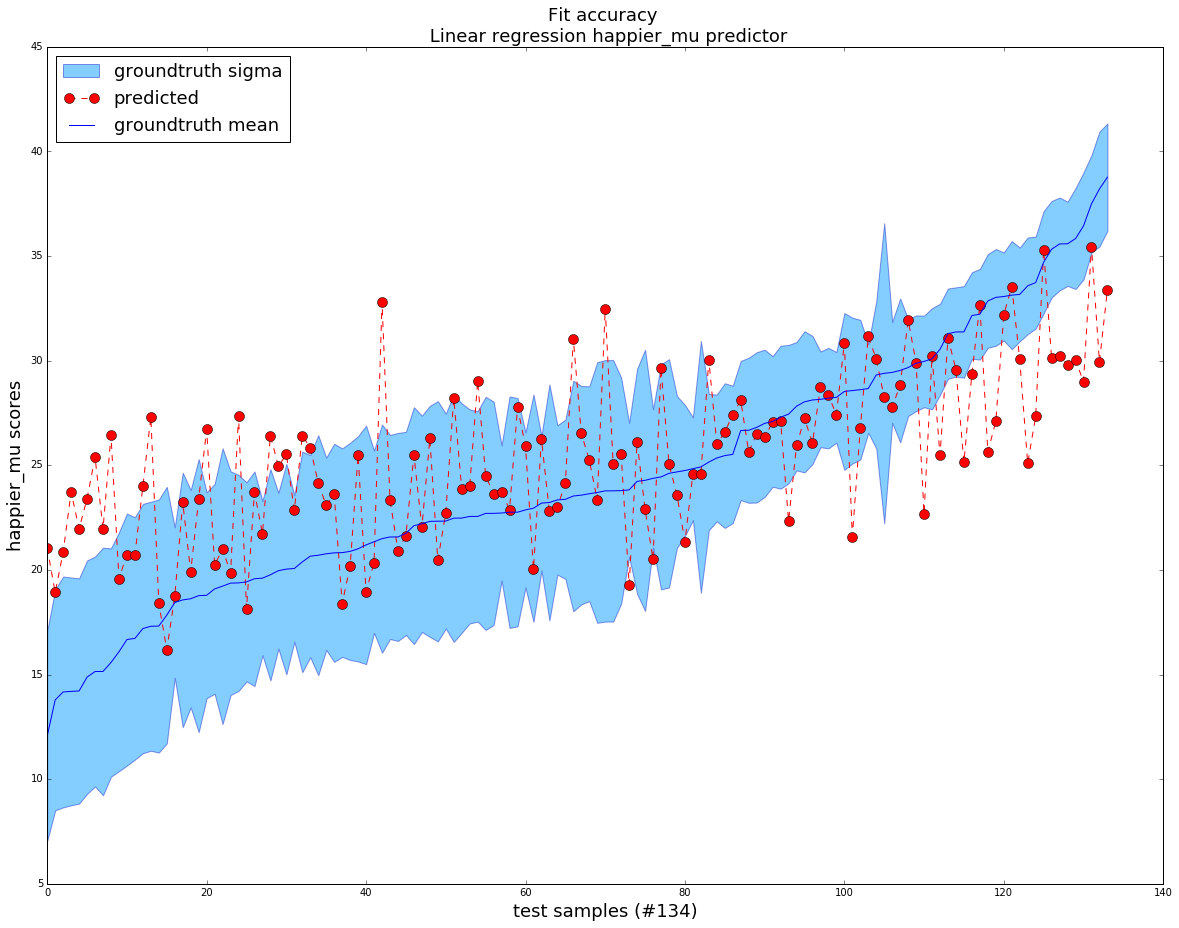

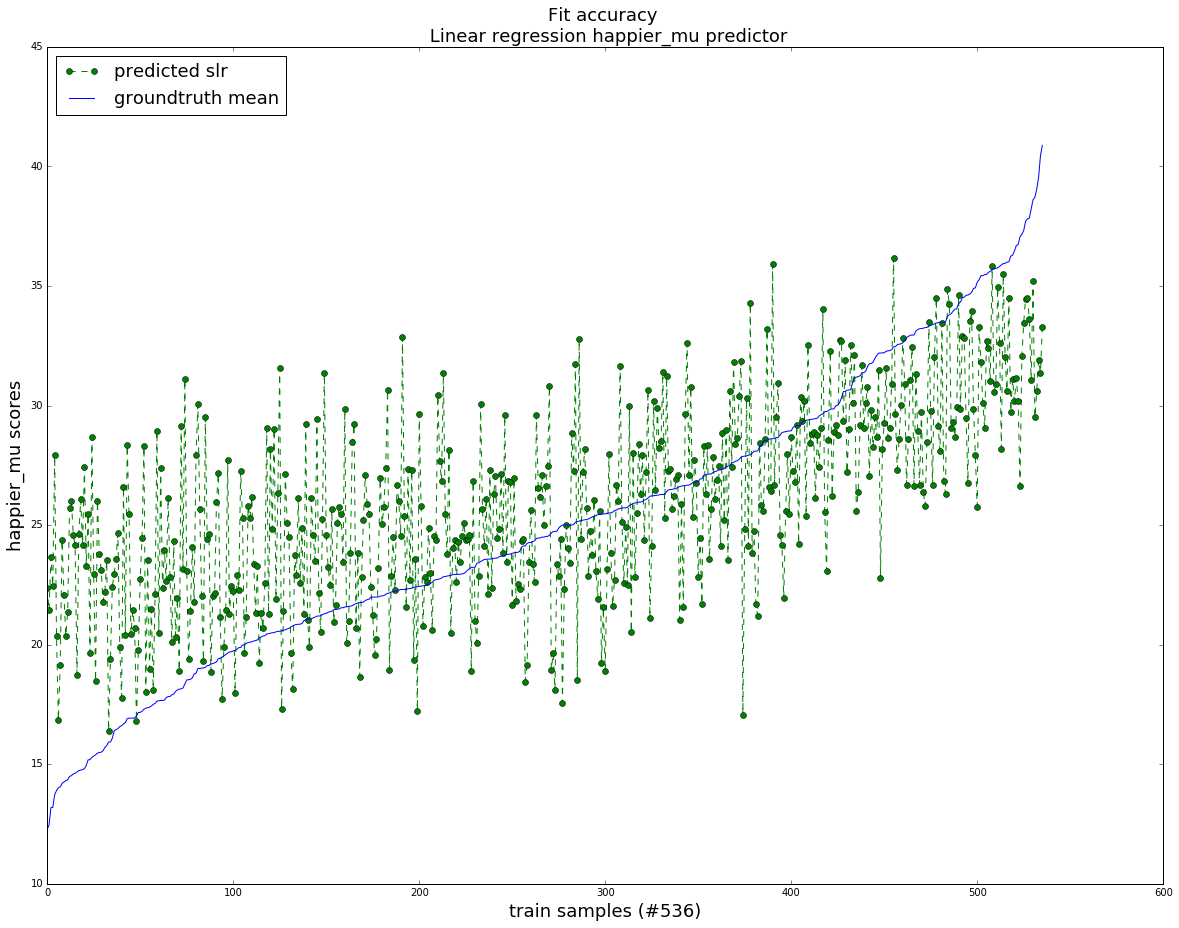

In [9]:
transformedDataLR = mapperLR.fit_transform(data.copy())

scores_WTS = pd.concat([scores, WTS_df], axis = 1)

X_trainLR, X_testLR, y_trainLR, y_testLR = model_selection.train_test_split(transformedDataLR, scores_WTS, test_size=0.2, random_state=42)
X_trainSLR = statsmodels.tools.add_constant(X_trainLR)
X_testSLR = statsmodels.tools.add_constant(X_testLR)

# getting prediction for complete dataset using our LR model for showing gallery motions
allDataSLR = statsmodels.tools.add_constant(transformedDataLR)

for i in range (0,1):
    LABEL_ID = i;
    LABEL = EMOSCORES[LABEL_ID]
    WT_COL = WTS_LABEL[LABEL_ID]
    predicted_name ="predicted_"+LABEL
    predicted_name_train ="predicted_"+LABEL+"_train"
    model_save_name = model_dir_name + "SLRTrained_"+LABEL+".pkl"
    
    lr.fit(X_trainLR, y_trainLR[EMOSCORES[LABEL_ID]],sample_weight=y_trainLR[WTS_LABEL[LABEL_ID]])
    slr = sm.WLS(y_trainLR[EMOSCORES[LABEL_ID]].values,X_trainSLR, weights = y_trainLR[WTS_LABEL[LABEL_ID]].values)
    fslr = slr.fit()
    print(fslr.params)
    #joblib.dump(fslr,model_save_name)

    ytest_pred_lr=lr.predict(X_testLR)
    ytrain_pred_lr=lr.predict(X_trainLR)
    ytest_pred_slr = fslr.predict(X_testSLR)
    ytrain_pred_slr=fslr.predict(X_trainSLR)
    allData_pred_slr = fslr.predict(allDataSLR)
    
    testmse = metrics.mean_squared_error(y_testLR[EMOSCORES[LABEL_ID]],ytest_pred_lr,sample_weight=y_testLR[WTS_LABEL[LABEL_ID]])
    testr2 = metrics.r2_score( y_testLR[EMOSCORES[LABEL_ID]],ytest_pred_lr,sample_weight=y_testLR[WTS_LABEL[LABEL_ID]])
    trainmse = metrics.mean_squared_error( y_trainLR[EMOSCORES[LABEL_ID]],ytrain_pred_lr,sample_weight=y_trainLR[WTS_LABEL[LABEL_ID]])
    trainr2 = metrics.r2_score( y_trainLR[EMOSCORES[LABEL_ID]],ytrain_pred_lr,sample_weight=y_trainLR[WTS_LABEL[LABEL_ID]])
    
    testmse_slr = metrics.mean_squared_error(y_testLR[EMOSCORES[LABEL_ID]],ytest_pred_slr,sample_weight=y_testLR[WTS_LABEL[LABEL_ID]])
    testr2_slr = metrics.r2_score( y_testLR[EMOSCORES[LABEL_ID]],ytest_pred_slr,sample_weight=y_testLR[WTS_LABEL[LABEL_ID]])
    trainmse_slr = metrics.mean_squared_error( y_trainLR[EMOSCORES[LABEL_ID]],ytrain_pred_slr,sample_weight=y_trainLR[WTS_LABEL[LABEL_ID]])
    trainr2_slr = metrics.r2_score( y_trainLR[EMOSCORES[LABEL_ID]],ytrain_pred_slr,sample_weight=y_trainLR[WTS_LABEL[LABEL_ID]])
    
    prstd_slr, iv_l_slr, iv_u_slr = wls_prediction_std(fslr, weights = [1])
    train_pred = fslr.get_prediction(X_trainSLR).summary_frame(alpha=0.05)
    train_pred.index = y_trainLR[LABEL].index
    test_pred = fslr.get_prediction(X_testSLR).summary_frame(alpha=0.05)
    test_pred.index = y_testLR[LABEL].index
    
    y_hat_lr = pd.DataFrame(ytest_pred_lr, columns=[predicted_name], index=y_testLR[LABEL].index) 
    y_hat_slr = pd.DataFrame(ytest_pred_slr, columns=[predicted_name], index=y_testLR[LABEL].index)     
    y_all_testlr = pd.concat([y_hat_lr, y_testLR[LABEL], y_testLR[EMOCONFIDENCE_INV[LABEL_ID]]], axis=1)
    y_all_testlr_sorted = y_all_testlr.sort_values(EMOSCORES[LABEL_ID],ascending=[True])
    y_all_testslr = pd.concat([y_hat_slr, test_pred["mean_ci_lower"], test_pred["mean_ci_upper"],
                               test_pred["obs_ci_lower"], test_pred["obs_ci_upper"],
                               y_testLR[LABEL], y_testLR[EMOCONFIDENCE_INV[LABEL_ID]]], axis=1)
    y_all_testslr_sorted = y_all_testslr.sort_values(EMOSCORES[LABEL_ID],ascending=[True])
    
    ytrain_hat_lr = pd.DataFrame(ytrain_pred_lr, columns=[predicted_name_train], index=y_trainLR[LABEL].index)
    ytrain_hat_slr = pd.DataFrame(ytrain_pred_slr, columns=[predicted_name_train], index=y_trainLR[LABEL].index) 
    ivl_hat_slr = pd.DataFrame(iv_l_slr, columns=["lower"], index=y_trainLR[LABEL].index) 
    ivu_hat_slr = pd.DataFrame(iv_u_slr, columns=["upper"], index=y_trainLR[LABEL].index) 
    
    y_all_trainlr = pd.concat([ytrain_hat_lr, y_trainLR[LABEL], y_trainLR[EMOCONFIDENCE_INV[LABEL_ID]]], axis=1)
    y_all_trainlr_sorted = y_all_trainlr.sort_values(LABEL,ascending=[True])
    y_all_trainslr = pd.concat([ytrain_hat_slr, ivl_hat_slr, ivu_hat_slr, 
                                train_pred["mean_ci_lower"], train_pred["mean_ci_upper"],
                                train_pred["obs_ci_lower"], train_pred["obs_ci_upper"],
                                y_trainLR[LABEL], y_trainLR[EMOCONFIDENCE_INV[LABEL_ID]]], axis=1)
    y_all_trainslr_sorted = y_all_trainslr.sort_values(LABEL,ascending=[True])
    
    %pylab inline
    pylab.rcParams['figure.figsize'] = (20, 15)
    ax =plt.figure()
    x = np.arange(0, y_all_testlr_sorted[predicted_name].size, 1)
    #plt.errorbar(x,y_all_testlr_sorted[predicted_name].values,fmt='r-*',label="predicted")
    #plt.errorbar(x,y_all_testslr_sorted[predicted_name].values,fmt='g--o',label="predicted slr")
    plt.errorbar(x,y_all_testslr_sorted[predicted_name].values,fmt='r--o', markersize='10',label="predicted")
    plt.fill_between(x, y_all_testlr_sorted[LABEL].values-y_all_testlr_sorted[EMOCONFIDENCE_INV[LABEL_ID]], y_all_testlr_sorted[LABEL].values+y_all_testlr_sorted[EMOCONFIDENCE_INV[LABEL_ID]],
        alpha=0.5, edgecolor='#1B2ACC', facecolor='#089FFF', label='groundtruth sigma')
    #plt.fill_between(x, y_all_testslr_sorted["mean_ci_lower"],y_all_testslr_sorted["mean_ci_upper"],alpha=0.3, edgecolor='r', facecolor='#089FFF', label='95% confidence interval')
    #plt.fill_between(x, y_all_testslr_sorted["obs_ci_lower"],y_all_testslr_sorted["obs_ci_upper"],alpha=0.3, edgecolor='g', facecolor='g', label='prediction interval')
    plt.errorbar(x,y_all_testlr_sorted[LABEL].values,fmt='b',label="groundtruth mean")
    #plt.title(model_dir_name,fontsize=18)
    plt.title('Fit accuracy \n Linear regression ' + LABEL + ' predictor',fontsize=18)
    plt.xlabel('test samples (#'+str(y_testLR[LABEL].size)+')',fontsize=18)
    plt.ylabel(LABEL +' scores',fontsize=18)
    pylab.legend(loc='upper left', fontsize=18)
    plt.show()
    fig_name = model_dir_name +"/" + LABEL+ "_SLRtestPredictionPAPER.pdf"
    ax.savefig(fig_name)
    
    pylab.rcParams['figure.figsize'] = (20, 15)
    ax =plt.figure()
    x = np.arange(0, y_all_trainlr_sorted[predicted_name_train].size, 1)
    #plt.errorbar(x,y_all_trainlr_sorted[predicted_name_train].values,fmt='r-*',label="predicted")
    plt.errorbar(x,y_all_trainslr_sorted[predicted_name_train].values,fmt='g--o',label="predicted slr")
#     plt.fill_between(x, y_all_trainlr_sorted[LABEL].values-y_all_trainlr_sorted[EMOCONFIDENCE_INV[LABEL_ID]], y_all_trainlr_sorted[LABEL].values+y_all_trainlr_sorted[EMOCONFIDENCE_INV[LABEL_ID]],
#         alpha=0.5, edgecolor='#1B2ACC', facecolor='#089FFF', label='groundtruth sigma')
    plt.errorbar(x,y_all_trainlr_sorted[LABEL].values,fmt='b',label="groundtruth mean")
    #plt.fill_between(x, y_all_trainslr_sorted["lower"],y_all_trainslr_sorted["upper"],alpha=0.5, edgecolor='r', facecolor='#089FFF'
     #               , label='prediction interval')
    #plt.fill_between(x, y_all_trainslr_sorted["mean_ci_lower"],y_all_trainslr_sorted["mean_ci_upper"],alpha=0.3, edgecolor='r', facecolor='r', label='95% confidence interval')
    #plt.fill_between(x, y_all_trainslr_sorted["obs_ci_lower"],y_all_trainslr_sorted["obs_ci_upper"],alpha=0.3, edgecolor='g', facecolor='g', label='prediction interval fn')
    #plt.title(model_dir_name,fontsize=18)
    plt.title('Fit accuracy \n Linear regression ' + LABEL + ' predictor',fontsize=18)
    plt.xlabel('train samples (#'+str(y_trainLR[LABEL].size)+')',fontsize=18)
    plt.ylabel(LABEL +' scores',fontsize=18)
    pylab.legend(loc='upper left', fontsize=18)
    plt.show()
#     fig_name = model_dir_name +"/" + LABEL+ "_LRtrainPrediction.pdf"
#     ax.savefig(fig_name)

#     save_info = pd.DataFrame(columns = ['regressor name','test wtd mse', 'test wtd r2', 'train wtd mse', 'train wtd r2', 'emotion'])
#     save_info.loc[1]= ["SLR", testmse_slr, testr2_slr, trainmse_slr, trainr2_slr, LABEL]
    
#     with open('C:\\Users\\rutad\\Documents\\bitbucket\\pythonTF\\LRBaseline\\LRBaselineExperiments.csv', 'a') as f:
#         save_info.to_csv(f, header=False, index=False)

#     predicted_name_SLR ="SLRpredicted_"+LABEL
#     allData_pred_slr_df = pd.DataFrame(allData_pred_slr, columns =[predicted_name_SLR], index = scores.index);
#     scores_concat = pd.concat([scores_concat, allData_pred_slr_df], axis =1)

In [10]:
# save_pred = scores_concat.copy();
# with open('C:\\Users\\rutad\\Documents\\bitbucket\\pythonTF\\LRBaseline\\sortedScoresWPredictions.csv', 'w') as f:
#     save_pred.to_csv(f, header=True, index=False)

In [11]:
export_testresults = pd.concat([y_all_testlr_sorted[LABEL], y_all_testlr_sorted[EMOCONFIDENCE_INV[LABEL_ID]], y_all_testlr_sorted[predicted_name]], axis = 1)#pd.DataFrame(columns = ['groundtruth_mu','groundtruth_sigma', 'predicted_mu'])
export_testresults.to_csv('C:\\Users\\rutad\\Documents\\bitbucket\\pythonTF\\LRBaseline\\export_testResults.csv',index=False)

In [12]:
max(iv_l_slr)

29.783427226370286

In [13]:
LABEL

'happier_mu'

In [14]:
fslr.params

array([ 22.70921329,  -0.49739174,   0.43501176,   0.18048968,
        -0.49100797,  -0.12632153,   0.20959529,  -0.1315793 ,
         0.67025964,   1.12883121,  -2.71626753,   1.55034779,
         7.98968029,   4.4749828 ,   2.8306612 ,   0.96046089,
         1.60507902,   3.29800131])

In [15]:
lr.coef_

array([-0.49739174,  0.43501176,  0.18048968, -0.49100797, -0.12632153,
        0.20959529, -0.1315793 ,  0.67025964,  1.12883121, -2.71626753,
       -1.69382554,  4.74550696,  1.23080947, -0.41351213, -2.28371244,
       -1.63909431,  0.05382798])

In [16]:
lr.intercept_

25.953386618624393

In [17]:
fslr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.466
Model:                            WLS   Adj. R-squared:                  0.450
Method:                 Least Squares   F-statistic:                     28.31
Date:                Thu, 29 Mar 2018   Prob (F-statistic):           1.68e-60
Time:                        14:29:39   Log-Likelihood:                -1647.3
No. Observations:                 536   AIC:                             3329.
Df Residuals:                     519   BIC:                             3401.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.7092      0.186    122.015      0.000      22.344      23.075
x1            -0.4974      0.199     -2.504      0.013      -0.888      -0.107
x2             0.4350      0.230      1.893      0.059      -0.016       0.886
x3             0.1805      0.217      0.832      0.406      -0.246       0.607
x4            -0.4910      0.203     -2.422      0.016      -0.889      -0.093
x5            -0.1263      0.202     -0.626      0.532      -0.523       0.270
x6             0.2096      0.205      1.023      0.307      -0.193       0.612
x7            -0.1316      0.216     -0.610      0.542      -0.555       0.292
x8             0.6703      0.195      3.431      0.001       0.286       1.054
x9             1.1288      0.207      5.450      0.000       0.722       1.536
x10           -2.7163      0.218    -12.463      0.000      -3.144      -2.288
x11            1.5503      0.492      3.153      0.002       0.584       2.516
x12            7.9897      0.468     17.080      0.000       7.071       8.909
x13            4.4750      0.610      7.338      0.000       3.277       5.673
x14            2.8307      0.500      5.663      0.000       1.849       3.813
x15            0.9605      0.534      1.798      0.073      -0.089       2.010
x16            1.6051      0.589      2.727      0.007       0.449       2.761
x17            3.2980      0.396      8.332      0.000       2.520       4.076
==============================================================================
Omnibus:                        2.601   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.272   Jarque-Bera (JB):                2.673
Skew:                           0.164   Prob(JB):                        0.263
Kurtosis:                       2.889   Cond. No.                     1.03e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.71e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [18]:
fslr.mse_total

18.333407904706089

In [19]:
fslr.predict()

array([ 21.20284029,  26.47948788,  31.82280879,  29.08013276,
        29.61373623,  27.27614692,  30.00405436,  29.35314849,
        18.0832826 ,  24.28318694,  26.10310795,  27.11254663,
        23.57457369,  25.09523123,  19.55925294,  29.22409961,
        28.65683514,  26.29638498,  23.83462301,  32.70220222,
        29.64837931,  22.01857769,  29.17909222,  29.74853305,
        21.55698236,  25.29437578,  24.39091843,  28.50137128,
        23.44361424,  28.33722395,  35.50316361,  29.59178706,
        24.07441956,  19.65419423,  25.46347538,  26.66189243,
        23.4437684 ,  23.82943243,  20.63317677,  23.13882186,
        29.07709911,  22.0627395 ,  27.72684833,  24.33405142,
        31.23058528,  27.96356241,  30.59529471,  31.39201804,
        22.31371541,  24.02717297,  18.14083894,  27.03855546,
        28.95263567,  24.81737747,  25.45506219,  30.20121065,
        25.45518915,  22.86391957,  28.59331087,  23.76881494,
        28.47001236,  22.3867475 ,  24.58672602,  19.75

In [20]:
trainmse

19.809588797199545

In [21]:
fslr.get_prediction(X_testSLR).summary_frame(alpha=0.05)

mean   mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  \
0    30.021858  0.737972      28.572078      31.471637     23.614972   
1    20.705976  0.746700      19.239050      22.172901     14.295189   
2    27.241951  0.530080      26.200586      28.283317     20.914965   
3    25.529564  0.468221      24.609722      26.449405     19.221440   
4    28.354150  0.767283      26.846787      29.861513     21.933990   
5    29.809225  0.829215      28.180194      31.438257     23.359414   
6    18.740339  0.799716      17.169260      20.311418     12.304921   
7    19.588582  0.731900      18.150731      21.026434     13.184386   
8    30.851560  0.709117      29.458467      32.244652     24.457263   
9    31.091533  1.046304      29.036020      33.147045     24.521034   
10   23.357687  0.719492      21.944211      24.771162     16.958919   
11   18.396894  0.788856      16.847150      19.946638     11.966651   
12   23.627705  0.525740      22.594865      24.660546     17.302116   
13   22.796413  0.736161      21.350191      24.242635     16.390332   
14   22.843885  0.627355      21.611417      24.076353     16.482651   
15   25.249636  0.657618      23.957716      26.541555     18.876617   
16   25.918621  0.657830      24.626283      27.210958     19.545517   
17   26.124461  1.177696      23.810824      28.438099     19.468694   
18   22.681489  0.777670      21.153722      24.209257     16.256507   
19   29.571096  0.790610      28.017907      31.124285     23.140022   
20   19.905529  0.974164      17.991740      21.819318     13.377979   
21   22.733534  0.658492      21.439896      24.027172     16.360166   
22   25.947253  1.181630      23.625888      28.268618     19.288796   
23   30.058331  0.964741      28.163053      31.953609     23.536184   
24   25.628158  0.835569      23.986644      27.269671     19.175183   
25   22.339432  0.506868      21.343667      23.335198     16.019791   
26   26.720577  0.654805      25.434183      28.006972     20.348675   
27   25.393226  0.610404      24.194059      26.592394     19.038360   
28   19.286952  0.803766      17.707918      20.865985     12.849587   
29   30.078821  1.235273      27.652071      32.505570     23.382894   
..         ...       ...            ...            ...           ...   
104  26.429541  0.875307      24.709961      28.149120     19.956267   
105  27.342219  0.998603      25.380417      29.304020     20.800431   
106  19.838238  0.702130      18.458872      21.217603     13.446918   
107  23.229483  0.522617      22.202779      24.256187     16.904893   
108  24.567074  0.473770      23.636332      25.497817     18.257352   
109  20.035042  1.207858      17.662150      22.407934     13.358446   
110  30.230604  0.697831      28.859684      31.601525     23.841102   
111  28.211776  1.016582      26.214654      30.208897     21.659309   
112  29.945109  0.990305      27.999609      31.890608     23.408192   
113  20.853409  1.201005      18.493980      23.212839     14.181586   
114  21.596804  0.707245      20.207389      22.986218     15.203307   
115  20.228962  0.817358      18.623225      21.834699     13.784995   
116  21.640485  1.180189      19.321951      23.959019     14.983014   
117  28.743077  0.768268      27.233779      30.252375     22.322462   
118  27.424067  0.581405      26.281870      28.566263     21.079705   
119  20.508251  0.752251      19.030420      21.986083     14.094960   
120  22.899326  0.578947      21.761958      24.036694     16.555832   
121  24.028326  0.835987      22.385992      25.670660     17.575142   
122  18.923709  0.781528      17.388361      20.459057     12.496920   
123  16.183809  0.916762      14.382789      17.984828      9.688426   
124  26.422840  0.515500      25.410118      27.435562     20.100505   
125  20.928165  1.083051      18.800462      23.055868     14.334726   
126  32.658647  0.579193      31.520796      33.796497     26.315065   
127  30.213297  0.673085      28.890991      31.53

In [22]:
if((fslr.get_prediction(X_testSLR).summary_frame(alpha=0.05)["mean"] - ytest_pred_slr).any()>0.0):
    print("uhoh")
else:
    print("phew")

phew


In [23]:
if((fslr.get_prediction(X_trainSLR).summary_frame(alpha=0.05)["obs_ci_lower"].values - iv_l_slr).any()>1):
    print("uhoh")
else:
    print("phew")

phew


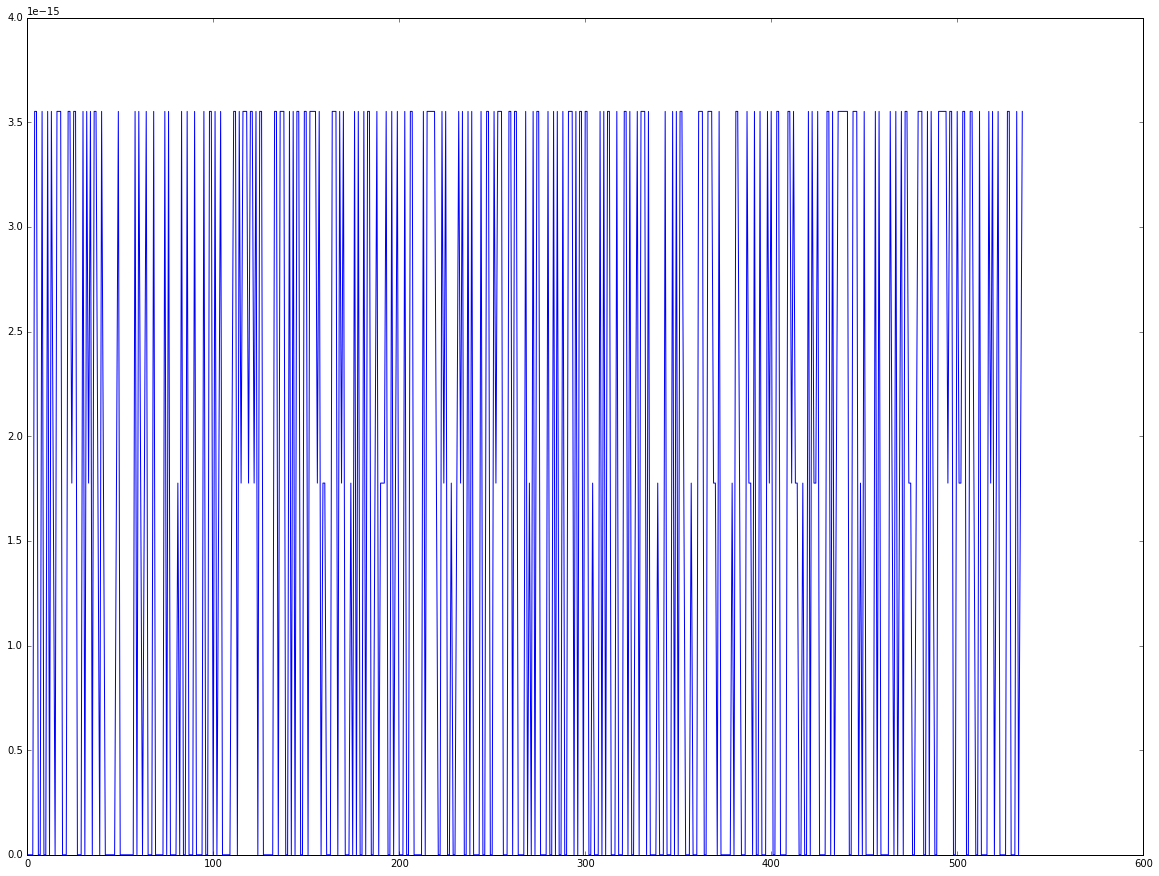

In [24]:
plt.plot(fslr.get_prediction(X_trainSLR).summary_frame(alpha=0.05)["obs_ci_lower"].values - iv_l_slr)

In [25]:
# reference: https://stackoverflow.com/questions/17559408/confidence-and-prediction-intervals-with-statsmodels
from statsmodels.stats.outliers_influence import summary_table
st, sum_data, ss2 = summary_table(fslr, alpha=0.05)

In [26]:
fittedvalues = sum_data[:,2]
print(np.max(np.abs(fslr.fittedvalues - fittedvalues)))

0.0


In [27]:
predict_mean_se  = sum_data[:,3]
predict_mean_ci_low, predict_mean_ci_upp = sum_data[:,4:6].T
predict_ci_low, predict_ci_upp = sum_data[:,6:8].T

In [28]:
print (np.max(np.abs(iv_l_slr - predict_ci_low)))
print (np.max(np.abs(iv_u_slr - predict_ci_upp)))

9868609.39752
9868609.39752


In [29]:
X_trainSLR[100]

array([ 1.        ,  0.6701364 ,  0.35791165,  0.35936359, -0.46417293,
       -0.4569186 ,  3.66901033,  0.16296883,  0.3887481 , -1.12167923,
       -1.29607152,  0.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  0.        ,  0.        ])

In [30]:
sum_data.shape

(536, 12)

In [31]:
X_trainSLR.shape

(536, 18)

In [32]:
data[FEATURES].std().values

array([ 0.13315188,  0.45050704,  0.49187453,  0.52001662,  0.51196117,
        0.26629413,  0.24590294,  0.0224489 ,  0.09667688,  0.48630937])